VAE

### VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
DEVICE = "cuda"

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(Encoder, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.out_mean = nn.Linear(hidden_dim, latent_dim)
        self.out_disp = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.hidden_layer(x))
        mu = self.out_mean(x)
        logvar = self.out_disp(x)
        return mu, logvar # logvar - логарифм дисперсии. Так будет удобнее считать KL divergence, в котором содержится log(var^2)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=400, output_dim=784):
        super(Decoder, self).__init__()
        self.hidden_layer = nn.Linear(latent_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        hidden = F.relu(self.hidden_layer(z))
        x_recon = torch.sigmoid(self.out_layer(hidden)) #на выходе получаем оттенки серого, 0 - черный, 1 - белый
        return x_recon

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std =  torch.exp(0.5 * logvar)
        epsilon = torch.rand_like(logvar).to(DEVICE) # Шум из N(0, 1)
        z = mu + std * epsilon
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Разворачиваем изображение в вектор
])

mnist_train = dset.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

In [ ]:
hidden_dim = 400 # размерность скрытого слоя
latent_dim = 20 # размерность латентного пространства


device = torch.device(DEVICE)
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        x_recon, mean, log_var = model(data)
        loss = loss_function(x_recon, data, mean, log_var)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch: 0 [0/60000 (0%)]	Loss: 544.241028
Epoch: 0 [12800/60000 (21%)]	Loss: 156.863800
Epoch: 0 [25600/60000 (43%)]	Loss: 130.068039
Epoch: 0 [38400/60000 (64%)]	Loss: 117.695015
Epoch: 0 [51200/60000 (85%)]	Loss: 115.943123
====> Epoch: 0 Average loss: 142.8891
Epoch: 1 [0/60000 (0%)]	Loss: 104.541893
Epoch: 1 [12800/60000 (21%)]	Loss: 99.565926
Epoch: 1 [25600/60000 (43%)]	Loss: 98.207069
Epoch: 1 [38400/60000 (64%)]	Loss: 102.818092
Epoch: 1 [51200/60000 (85%)]	Loss: 96.262238
====> Epoch: 1 Average loss: 101.6908
Epoch: 2 [0/60000 (0%)]	Loss: 96.713280
Epoch: 2 [12800/60000 (21%)]	Loss: 96.473473
Epoch: 2 [25600/60000 (43%)]	Loss: 95.900955
Epoch: 2 [38400/60000 (64%)]	Loss: 95.666367
Epoch: 2 [51200/60000 (85%)]	Loss: 99.717361
====> Epoch: 2 Average loss: 96.3287
Epoch: 3 [0/60000 (0%)]	Loss: 94.767029
Epoch: 3 [12800/60000 (21%)]	Loss: 94.243416
Epoch: 3 [25600/60000 (43%)]	Loss: 91.810722
Epoch: 3 [38400/60000 (64%)]	Loss: 95.986900
Epoch: 3 [51200/60000 (85%)]	Loss: 92.292122


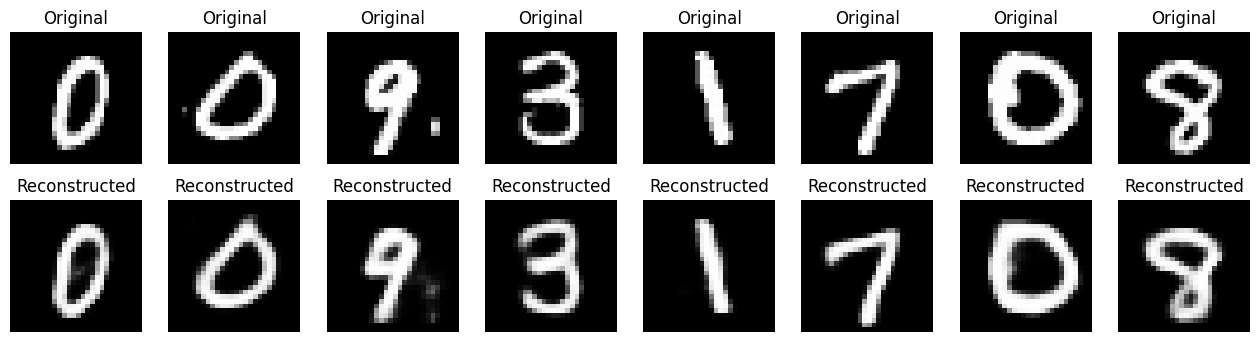

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

mnist_test = dset.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=16, shuffle=True)

model.eval() # Переведите модель в режим оценки


# ---- Визуализация: Реконструкция тестовых изображений ----
# Получите партию тестовых изображений
data_iter = iter(test_loader)
images, _ = next(data_iter)
images = images.to(device)

with torch.no_grad():
    recon_images, mu, logvar = model(images)

def plot_images(original, reconstructed, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # Оригинальные изображения
        plt.subplot(2, n, i+1)
        plt.imshow(original[i].cpu().view(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis("off")
        # Реконструированные изображения
        plt.subplot(2, n, i+n+1)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

plot_images(images, recon_images, n=8)

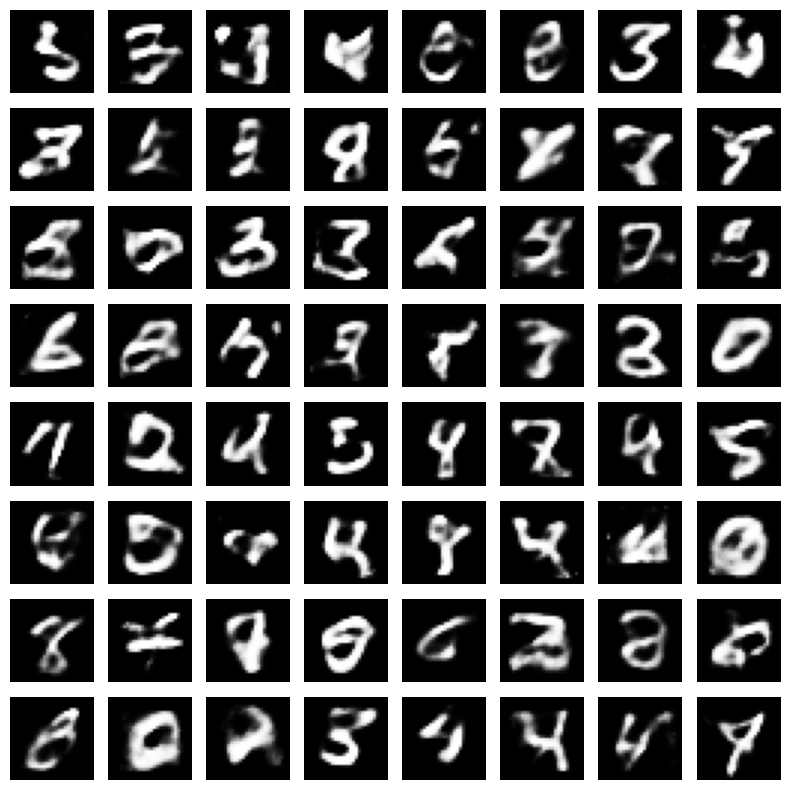

In [ ]:
with torch.no_grad():
    # Выборка латентных векторов z из стандартного нормального распределения
    # YOUR CODE HERE:
    z = torch.randn(64, latent_dim)
    generated_images = model.decoder(z.to(DEVICE))

def plot_generated(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28,28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_generated(generated_images)

### Conditional VAE

In [ ]:
class ConditionalEncoder(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=400, latent_dim=20):
        super(ConditionalEncoder, self).__init__()
        self.hidden_layer = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.out_mean = nn.Linear(hidden_dim, latent_dim)
        self.out_disp = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, c):
        x = torch.cat([x, c], 1)
        x = F.relu(self.hidden_layer(x))
        mu = self.out_mean(x)
        logvar = self.out_disp(x)
        return mu, logvar

In [ ]:
class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim=20, condition_dim=10, hidden_dim=400, output_dim=784):
        super(ConditionalDecoder, self).__init__()
        self.hidden_layer = nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.out_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, c):
        z = torch.cat([z, c], 1)
        hidden = F.relu(self.hidden_layer(z))
        x_recon = torch.sigmoid(self.out_layer(hidden))
        return x_recon

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=400, latent_dim=50):
        super(ConditionalVAE, self).__init__()
        self.encoder = ConditionalEncoder(input_dim, condition_dim, hidden_dim, latent_dim)
        self.decoder = ConditionalDecoder(latent_dim, condition_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std =  torch.exp(0.5 * logvar)
        epsilon = torch.rand_like(logvar).to(DEVICE)
        z = mu + std * epsilon
        return z

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, c)
        return x_recon, mu, logvar

In [ ]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = dset.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = dset.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
hidden_dim = 400 # размерность скрытого слоя
latent_dim = 20 # размерность латентного пространства

model = ConditionalVAE(input_dim=784, condition_dim=10, hidden_dim=hidden_dim, latent_dim=latent_dim).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 50 # Для получения более презентабельного результата используйте 50 и больше эпох
model.train()
for epoch in tqdm(range(1, num_epochs + 1)):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        ## YOUR CODE HERE
        ## TODO: Переместите входные данные (data) на правильное устройство
        ## TODO: Перенесите метки классов (labels) на правильное устройство
        ## TODO: С помощью функции F.one_hot получите массив векторов - закодированных меток классов для вашего батча
        ## TODO: Обнулите градиенты
        ## TODO: Вычислите выходы энкодера (recon_batch, mu, logvar)
        ## TODO: Рассчитайте функцию потерь (loss)
        ## TODO: Выполните обратное распространение градиентов с учетом функции потерь
        ## TODO: Обновите общий loss, добавив текущий loss
        ## TODO: Выполните шаг оптимизатора
        labels = labels.to(DEVICE)
        data = data.to(DEVICE)
        conditions = F.one_hot(labels, 10)

        optimizer.zero_grad()

        x_recon, mean, log_var = model(data, conditions)
        loss = loss_function(x_recon, data, mean, log_var)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 [0/60000 (0%)]	Loss: 548.213684
Epoch: 1 [12800/60000 (21%)]	Loss: 152.058517
Epoch: 1 [25600/60000 (43%)]	Loss: 130.877228
Epoch: 1 [38400/60000 (64%)]	Loss: 115.621986
Epoch: 1 [51200/60000 (85%)]	Loss: 106.628914


  2%|▏         | 1/50 [00:07<05:46,  7.07s/it]

====> Epoch: 1 Average loss: 142.9953
Epoch: 2 [0/60000 (0%)]	Loss: 109.244728
Epoch: 2 [12800/60000 (21%)]	Loss: 106.198868
Epoch: 2 [25600/60000 (43%)]	Loss: 100.220779
Epoch: 2 [38400/60000 (64%)]	Loss: 99.486023
Epoch: 2 [51200/60000 (85%)]	Loss: 98.395721


  4%|▍         | 2/50 [00:13<05:24,  6.76s/it]

====> Epoch: 2 Average loss: 101.6227
Epoch: 3 [0/60000 (0%)]	Loss: 96.147774
Epoch: 3 [12800/60000 (21%)]	Loss: 97.210396
Epoch: 3 [25600/60000 (43%)]	Loss: 93.530373
Epoch: 3 [38400/60000 (64%)]	Loss: 92.700645
Epoch: 3 [51200/60000 (85%)]	Loss: 92.519569


  6%|▌         | 3/50 [00:20<05:26,  6.95s/it]

====> Epoch: 3 Average loss: 95.4236
Epoch: 4 [0/60000 (0%)]	Loss: 90.167336
Epoch: 4 [12800/60000 (21%)]	Loss: 92.300835
Epoch: 4 [25600/60000 (43%)]	Loss: 94.187492
Epoch: 4 [38400/60000 (64%)]	Loss: 92.677788
Epoch: 4 [51200/60000 (85%)]	Loss: 89.096909


  8%|▊         | 4/50 [00:27<05:17,  6.89s/it]

====> Epoch: 4 Average loss: 92.3132
Epoch: 5 [0/60000 (0%)]	Loss: 92.645851
Epoch: 5 [12800/60000 (21%)]	Loss: 89.540688
Epoch: 5 [25600/60000 (43%)]	Loss: 88.783958
Epoch: 5 [38400/60000 (64%)]	Loss: 89.020592
Epoch: 5 [51200/60000 (85%)]	Loss: 89.292679


 10%|█         | 5/50 [00:34<05:07,  6.83s/it]

====> Epoch: 5 Average loss: 90.1061
Epoch: 6 [0/60000 (0%)]	Loss: 89.783920
Epoch: 6 [12800/60000 (21%)]	Loss: 92.285995
Epoch: 6 [25600/60000 (43%)]	Loss: 89.724594
Epoch: 6 [38400/60000 (64%)]	Loss: 91.197716
Epoch: 6 [51200/60000 (85%)]	Loss: 89.583054


 12%|█▏        | 6/50 [00:41<05:04,  6.91s/it]

====> Epoch: 6 Average loss: 88.4401
Epoch: 7 [0/60000 (0%)]	Loss: 85.955795
Epoch: 7 [12800/60000 (21%)]	Loss: 85.889389
Epoch: 7 [25600/60000 (43%)]	Loss: 88.402641
Epoch: 7 [38400/60000 (64%)]	Loss: 82.590454
Epoch: 7 [51200/60000 (85%)]	Loss: 86.280998


 14%|█▍        | 7/50 [00:47<04:51,  6.78s/it]

====> Epoch: 7 Average loss: 87.1797
Epoch: 8 [0/60000 (0%)]	Loss: 85.776054
Epoch: 8 [12800/60000 (21%)]	Loss: 87.617271
Epoch: 8 [25600/60000 (43%)]	Loss: 88.893036
Epoch: 8 [38400/60000 (64%)]	Loss: 84.567978
Epoch: 8 [51200/60000 (85%)]	Loss: 84.684692


 16%|█▌        | 8/50 [00:54<04:48,  6.87s/it]

====> Epoch: 8 Average loss: 86.1988
Epoch: 9 [0/60000 (0%)]	Loss: 82.280167
Epoch: 9 [12800/60000 (21%)]	Loss: 84.695198
Epoch: 9 [25600/60000 (43%)]	Loss: 86.026581
Epoch: 9 [38400/60000 (64%)]	Loss: 84.108505
Epoch: 9 [51200/60000 (85%)]	Loss: 83.116798


 18%|█▊        | 9/50 [01:01<04:36,  6.75s/it]

====> Epoch: 9 Average loss: 85.4269
Epoch: 10 [0/60000 (0%)]	Loss: 82.383461
Epoch: 10 [12800/60000 (21%)]	Loss: 83.082985
Epoch: 10 [25600/60000 (43%)]	Loss: 82.993546
Epoch: 10 [38400/60000 (64%)]	Loss: 82.732399
Epoch: 10 [51200/60000 (85%)]	Loss: 80.825569


 20%|██        | 10/50 [01:08<04:34,  6.85s/it]

====> Epoch: 10 Average loss: 84.7804
Epoch: 11 [0/60000 (0%)]	Loss: 84.127090
Epoch: 11 [12800/60000 (21%)]	Loss: 81.559494
Epoch: 11 [25600/60000 (43%)]	Loss: 84.767593
Epoch: 11 [38400/60000 (64%)]	Loss: 83.622520
Epoch: 11 [51200/60000 (85%)]	Loss: 78.751839


 22%|██▏       | 11/50 [01:15<04:24,  6.79s/it]

====> Epoch: 11 Average loss: 84.2382
Epoch: 12 [0/60000 (0%)]	Loss: 84.480698
Epoch: 12 [12800/60000 (21%)]	Loss: 85.294006
Epoch: 12 [25600/60000 (43%)]	Loss: 84.889420
Epoch: 12 [38400/60000 (64%)]	Loss: 82.198029
Epoch: 12 [51200/60000 (85%)]	Loss: 83.333145


 24%|██▍       | 12/50 [01:22<04:19,  6.82s/it]

====> Epoch: 12 Average loss: 83.8760
Epoch: 13 [0/60000 (0%)]	Loss: 86.231758
Epoch: 13 [12800/60000 (21%)]	Loss: 82.924294
Epoch: 13 [25600/60000 (43%)]	Loss: 87.660721
Epoch: 13 [38400/60000 (64%)]	Loss: 82.416931
Epoch: 13 [51200/60000 (85%)]	Loss: 86.308105


 26%|██▌       | 13/50 [01:29<04:15,  6.91s/it]

====> Epoch: 13 Average loss: 83.4610
Epoch: 14 [0/60000 (0%)]	Loss: 79.328316
Epoch: 14 [12800/60000 (21%)]	Loss: 84.091225
Epoch: 14 [25600/60000 (43%)]	Loss: 83.684799
Epoch: 14 [38400/60000 (64%)]	Loss: 88.452919
Epoch: 14 [51200/60000 (85%)]	Loss: 82.555077


 28%|██▊       | 14/50 [01:35<04:04,  6.78s/it]

====> Epoch: 14 Average loss: 83.1285
Epoch: 15 [0/60000 (0%)]	Loss: 81.898438
Epoch: 15 [12800/60000 (21%)]	Loss: 83.451324
Epoch: 15 [25600/60000 (43%)]	Loss: 82.517647
Epoch: 15 [38400/60000 (64%)]	Loss: 80.794441
Epoch: 15 [51200/60000 (85%)]	Loss: 84.078140


 30%|███       | 15/50 [01:42<04:00,  6.88s/it]

====> Epoch: 15 Average loss: 82.8460
Epoch: 16 [0/60000 (0%)]	Loss: 83.721428
Epoch: 16 [12800/60000 (21%)]	Loss: 83.215256
Epoch: 16 [25600/60000 (43%)]	Loss: 84.779526
Epoch: 16 [38400/60000 (64%)]	Loss: 81.862946
Epoch: 16 [51200/60000 (85%)]	Loss: 83.668724


 32%|███▏      | 16/50 [01:49<03:49,  6.76s/it]

====> Epoch: 16 Average loss: 82.5790
Epoch: 17 [0/60000 (0%)]	Loss: 80.777458
Epoch: 17 [12800/60000 (21%)]	Loss: 84.614006
Epoch: 17 [25600/60000 (43%)]	Loss: 81.786232
Epoch: 17 [38400/60000 (64%)]	Loss: 81.233406
Epoch: 17 [51200/60000 (85%)]	Loss: 80.861755


 34%|███▍      | 17/50 [01:56<03:46,  6.86s/it]

====> Epoch: 17 Average loss: 82.3364
Epoch: 18 [0/60000 (0%)]	Loss: 83.606857
Epoch: 18 [12800/60000 (21%)]	Loss: 81.171219
Epoch: 18 [25600/60000 (43%)]	Loss: 81.686935
Epoch: 18 [38400/60000 (64%)]	Loss: 81.317184
Epoch: 18 [51200/60000 (85%)]	Loss: 83.072357


 36%|███▌      | 18/50 [02:03<03:37,  6.80s/it]

====> Epoch: 18 Average loss: 82.1523
Epoch: 19 [0/60000 (0%)]	Loss: 84.513367
Epoch: 19 [12800/60000 (21%)]	Loss: 83.793213
Epoch: 19 [25600/60000 (43%)]	Loss: 81.560120
Epoch: 19 [38400/60000 (64%)]	Loss: 84.358078
Epoch: 19 [51200/60000 (85%)]	Loss: 84.931213


 38%|███▊      | 19/50 [02:09<03:32,  6.84s/it]

====> Epoch: 19 Average loss: 81.9703
Epoch: 20 [0/60000 (0%)]	Loss: 81.500641
Epoch: 20 [12800/60000 (21%)]	Loss: 82.987701
Epoch: 20 [25600/60000 (43%)]	Loss: 84.023933
Epoch: 20 [38400/60000 (64%)]	Loss: 81.166176
Epoch: 20 [51200/60000 (85%)]	Loss: 78.112915


 40%|████      | 20/50 [02:17<03:28,  6.95s/it]

====> Epoch: 20 Average loss: 81.7946
Epoch: 21 [0/60000 (0%)]	Loss: 82.224281
Epoch: 21 [12800/60000 (21%)]	Loss: 84.853302
Epoch: 21 [25600/60000 (43%)]	Loss: 82.578659
Epoch: 21 [38400/60000 (64%)]	Loss: 82.495918
Epoch: 21 [51200/60000 (85%)]	Loss: 81.072906


 42%|████▏     | 21/50 [02:23<03:17,  6.81s/it]

====> Epoch: 21 Average loss: 81.6549
Epoch: 22 [0/60000 (0%)]	Loss: 81.351982
Epoch: 22 [12800/60000 (21%)]	Loss: 82.105621
Epoch: 22 [25600/60000 (43%)]	Loss: 83.795479
Epoch: 22 [38400/60000 (64%)]	Loss: 81.656830
Epoch: 22 [51200/60000 (85%)]	Loss: 82.511887


 44%|████▍     | 22/50 [02:30<03:13,  6.90s/it]

====> Epoch: 22 Average loss: 81.5329
Epoch: 23 [0/60000 (0%)]	Loss: 85.283676
Epoch: 23 [12800/60000 (21%)]	Loss: 80.571472
Epoch: 23 [25600/60000 (43%)]	Loss: 78.949883
Epoch: 23 [38400/60000 (64%)]	Loss: 82.094330
Epoch: 23 [51200/60000 (85%)]	Loss: 83.434807


 46%|████▌     | 23/50 [02:37<03:02,  6.75s/it]

====> Epoch: 23 Average loss: 81.3737
Epoch: 24 [0/60000 (0%)]	Loss: 82.653923
Epoch: 24 [12800/60000 (21%)]	Loss: 78.614342
Epoch: 24 [25600/60000 (43%)]	Loss: 79.555779
Epoch: 24 [38400/60000 (64%)]	Loss: 83.460052
Epoch: 24 [51200/60000 (85%)]	Loss: 78.442047


 48%|████▊     | 24/50 [02:44<02:58,  6.87s/it]

====> Epoch: 24 Average loss: 81.2878
Epoch: 25 [0/60000 (0%)]	Loss: 86.575790
Epoch: 25 [12800/60000 (21%)]	Loss: 82.657867
Epoch: 25 [25600/60000 (43%)]	Loss: 83.579132
Epoch: 25 [38400/60000 (64%)]	Loss: 78.651749
Epoch: 25 [51200/60000 (85%)]	Loss: 80.445992


 50%|█████     | 25/50 [02:50<02:50,  6.81s/it]

====> Epoch: 25 Average loss: 81.1617
Epoch: 26 [0/60000 (0%)]	Loss: 79.764175
Epoch: 26 [12800/60000 (21%)]	Loss: 82.501633
Epoch: 26 [25600/60000 (43%)]	Loss: 84.456711
Epoch: 26 [38400/60000 (64%)]	Loss: 81.964615
Epoch: 26 [51200/60000 (85%)]	Loss: 82.596107


 52%|█████▏    | 26/50 [02:57<02:44,  6.85s/it]

====> Epoch: 26 Average loss: 81.0423
Epoch: 27 [0/60000 (0%)]	Loss: 82.095474
Epoch: 27 [12800/60000 (21%)]	Loss: 79.140121
Epoch: 27 [25600/60000 (43%)]	Loss: 82.186668
Epoch: 27 [38400/60000 (64%)]	Loss: 84.704056
Epoch: 27 [51200/60000 (85%)]	Loss: 82.111534


 54%|█████▍    | 27/50 [03:05<02:39,  6.92s/it]

====> Epoch: 27 Average loss: 80.9200
Epoch: 28 [0/60000 (0%)]	Loss: 81.020905
Epoch: 28 [12800/60000 (21%)]	Loss: 82.809654
Epoch: 28 [25600/60000 (43%)]	Loss: 79.627838
Epoch: 28 [38400/60000 (64%)]	Loss: 81.604691
Epoch: 28 [51200/60000 (85%)]	Loss: 79.250046


 56%|█████▌    | 28/50 [03:11<02:29,  6.78s/it]

====> Epoch: 28 Average loss: 80.8614
Epoch: 29 [0/60000 (0%)]	Loss: 81.145454
Epoch: 29 [12800/60000 (21%)]	Loss: 82.279892
Epoch: 29 [25600/60000 (43%)]	Loss: 76.880539
Epoch: 29 [38400/60000 (64%)]	Loss: 79.621529
Epoch: 29 [51200/60000 (85%)]	Loss: 82.347290


 58%|█████▊    | 29/50 [03:18<02:24,  6.89s/it]

====> Epoch: 29 Average loss: 80.7936
Epoch: 30 [0/60000 (0%)]	Loss: 81.472832
Epoch: 30 [12800/60000 (21%)]	Loss: 80.386505
Epoch: 30 [25600/60000 (43%)]	Loss: 77.414230
Epoch: 30 [38400/60000 (64%)]	Loss: 79.266495
Epoch: 30 [51200/60000 (85%)]	Loss: 84.626633


 60%|██████    | 30/50 [03:25<02:15,  6.76s/it]

====> Epoch: 30 Average loss: 80.6951
Epoch: 31 [0/60000 (0%)]	Loss: 84.776436
Epoch: 31 [12800/60000 (21%)]	Loss: 75.896500
Epoch: 31 [25600/60000 (43%)]	Loss: 83.091942
Epoch: 31 [38400/60000 (64%)]	Loss: 78.528313
Epoch: 31 [51200/60000 (85%)]	Loss: 81.970055


 62%|██████▏   | 31/50 [03:32<02:09,  6.84s/it]

====> Epoch: 31 Average loss: 80.5766
Epoch: 32 [0/60000 (0%)]	Loss: 81.979691
Epoch: 32 [12800/60000 (21%)]	Loss: 80.089470
Epoch: 32 [25600/60000 (43%)]	Loss: 79.960678
Epoch: 32 [38400/60000 (64%)]	Loss: 79.339310
Epoch: 32 [51200/60000 (85%)]	Loss: 84.207169


 64%|██████▍   | 32/50 [03:38<02:01,  6.72s/it]

====> Epoch: 32 Average loss: 80.5156
Epoch: 33 [0/60000 (0%)]	Loss: 82.318329
Epoch: 33 [12800/60000 (21%)]	Loss: 84.928696
Epoch: 33 [25600/60000 (43%)]	Loss: 84.831879
Epoch: 33 [38400/60000 (64%)]	Loss: 82.142723
Epoch: 33 [51200/60000 (85%)]	Loss: 80.290436


 66%|██████▌   | 33/50 [03:45<01:55,  6.79s/it]

====> Epoch: 33 Average loss: 80.4551
Epoch: 34 [0/60000 (0%)]	Loss: 81.040260
Epoch: 34 [12800/60000 (21%)]	Loss: 78.324471
Epoch: 34 [25600/60000 (43%)]	Loss: 80.437073
Epoch: 34 [38400/60000 (64%)]	Loss: 79.341301
Epoch: 34 [51200/60000 (85%)]	Loss: 78.505753


 68%|██████▊   | 34/50 [03:52<01:50,  6.88s/it]

====> Epoch: 34 Average loss: 80.3902
Epoch: 35 [0/60000 (0%)]	Loss: 82.196640
Epoch: 35 [12800/60000 (21%)]	Loss: 78.013000
Epoch: 35 [25600/60000 (43%)]	Loss: 80.864494
Epoch: 35 [38400/60000 (64%)]	Loss: 79.294823
Epoch: 35 [51200/60000 (85%)]	Loss: 81.742172


 70%|███████   | 35/50 [03:59<01:41,  6.78s/it]

====> Epoch: 35 Average loss: 80.3248
Epoch: 36 [0/60000 (0%)]	Loss: 76.186607
Epoch: 36 [12800/60000 (21%)]	Loss: 79.406357
Epoch: 36 [25600/60000 (43%)]	Loss: 79.687813
Epoch: 36 [38400/60000 (64%)]	Loss: 80.504944
Epoch: 36 [51200/60000 (85%)]	Loss: 77.504242


 72%|███████▏  | 36/50 [04:06<01:36,  6.87s/it]

====> Epoch: 36 Average loss: 80.2469
Epoch: 37 [0/60000 (0%)]	Loss: 76.352394
Epoch: 37 [12800/60000 (21%)]	Loss: 78.878677
Epoch: 37 [25600/60000 (43%)]	Loss: 83.150604
Epoch: 37 [38400/60000 (64%)]	Loss: 77.232742
Epoch: 37 [51200/60000 (85%)]	Loss: 78.429581


 74%|███████▍  | 37/50 [04:12<01:27,  6.74s/it]

====> Epoch: 37 Average loss: 80.1790
Epoch: 38 [0/60000 (0%)]	Loss: 82.126434
Epoch: 38 [12800/60000 (21%)]	Loss: 79.943466
Epoch: 38 [25600/60000 (43%)]	Loss: 80.585556
Epoch: 38 [38400/60000 (64%)]	Loss: 79.675415
Epoch: 38 [51200/60000 (85%)]	Loss: 77.749466


 76%|███████▌  | 38/50 [04:19<01:21,  6.83s/it]

====> Epoch: 38 Average loss: 80.1434
Epoch: 39 [0/60000 (0%)]	Loss: 79.622856
Epoch: 39 [12800/60000 (21%)]	Loss: 80.481171
Epoch: 39 [25600/60000 (43%)]	Loss: 78.911453
Epoch: 39 [38400/60000 (64%)]	Loss: 83.190186
Epoch: 39 [51200/60000 (85%)]	Loss: 77.977608


 78%|███████▊  | 39/50 [04:26<01:13,  6.71s/it]

====> Epoch: 39 Average loss: 80.0650
Epoch: 40 [0/60000 (0%)]	Loss: 81.332222
Epoch: 40 [12800/60000 (21%)]	Loss: 80.714127
Epoch: 40 [25600/60000 (43%)]	Loss: 80.360306
Epoch: 40 [38400/60000 (64%)]	Loss: 81.014214
Epoch: 40 [51200/60000 (85%)]	Loss: 79.896667


 80%|████████  | 40/50 [04:33<01:07,  6.79s/it]

====> Epoch: 40 Average loss: 80.0500
Epoch: 41 [0/60000 (0%)]	Loss: 82.229828
Epoch: 41 [12800/60000 (21%)]	Loss: 80.380264
Epoch: 41 [25600/60000 (43%)]	Loss: 81.004745
Epoch: 41 [38400/60000 (64%)]	Loss: 76.727448
Epoch: 41 [51200/60000 (85%)]	Loss: 82.146126


 82%|████████▏ | 41/50 [04:40<01:01,  6.84s/it]

====> Epoch: 41 Average loss: 79.9686
Epoch: 42 [0/60000 (0%)]	Loss: 82.228607
Epoch: 42 [12800/60000 (21%)]	Loss: 79.826347
Epoch: 42 [25600/60000 (43%)]	Loss: 78.535858
Epoch: 42 [38400/60000 (64%)]	Loss: 80.509148
Epoch: 42 [51200/60000 (85%)]	Loss: 77.494919


 84%|████████▍ | 42/50 [04:46<00:53,  6.75s/it]

====> Epoch: 42 Average loss: 79.9494
Epoch: 43 [0/60000 (0%)]	Loss: 82.146935
Epoch: 43 [12800/60000 (21%)]	Loss: 83.038536
Epoch: 43 [25600/60000 (43%)]	Loss: 80.079834
Epoch: 43 [38400/60000 (64%)]	Loss: 79.536774
Epoch: 43 [51200/60000 (85%)]	Loss: 79.573105


 86%|████████▌ | 43/50 [04:53<00:47,  6.84s/it]

====> Epoch: 43 Average loss: 79.8936
Epoch: 44 [0/60000 (0%)]	Loss: 81.666077
Epoch: 44 [12800/60000 (21%)]	Loss: 81.705406
Epoch: 44 [25600/60000 (43%)]	Loss: 83.061569
Epoch: 44 [38400/60000 (64%)]	Loss: 79.839264
Epoch: 44 [51200/60000 (85%)]	Loss: 78.205589


 88%|████████▊ | 44/50 [05:00<00:40,  6.73s/it]

====> Epoch: 44 Average loss: 79.8738
Epoch: 45 [0/60000 (0%)]	Loss: 81.655983
Epoch: 45 [12800/60000 (21%)]	Loss: 79.116348
Epoch: 45 [25600/60000 (43%)]	Loss: 79.490967
Epoch: 45 [38400/60000 (64%)]	Loss: 80.300583
Epoch: 45 [51200/60000 (85%)]	Loss: 78.012444


 90%|█████████ | 45/50 [05:07<00:34,  6.82s/it]

====> Epoch: 45 Average loss: 79.7659
Epoch: 46 [0/60000 (0%)]	Loss: 77.492920
Epoch: 46 [12800/60000 (21%)]	Loss: 82.580620
Epoch: 46 [25600/60000 (43%)]	Loss: 76.266281
Epoch: 46 [38400/60000 (64%)]	Loss: 79.484520
Epoch: 46 [51200/60000 (85%)]	Loss: 80.098022


 92%|█████████▏| 46/50 [05:13<00:26,  6.70s/it]

====> Epoch: 46 Average loss: 79.7443
Epoch: 47 [0/60000 (0%)]	Loss: 79.399849
Epoch: 47 [12800/60000 (21%)]	Loss: 78.758469
Epoch: 47 [25600/60000 (43%)]	Loss: 80.015099
Epoch: 47 [38400/60000 (64%)]	Loss: 78.120384
Epoch: 47 [51200/60000 (85%)]	Loss: 81.385048


 94%|█████████▍| 47/50 [05:20<00:20,  6.83s/it]

====> Epoch: 47 Average loss: 79.6984
Epoch: 48 [0/60000 (0%)]	Loss: 81.418877
Epoch: 48 [12800/60000 (21%)]	Loss: 79.326027
Epoch: 48 [25600/60000 (43%)]	Loss: 83.312111
Epoch: 48 [38400/60000 (64%)]	Loss: 79.441071
Epoch: 48 [51200/60000 (85%)]	Loss: 79.558289


 96%|█████████▌| 48/50 [05:27<00:13,  6.84s/it]

====> Epoch: 48 Average loss: 79.6863
Epoch: 49 [0/60000 (0%)]	Loss: 79.041588
Epoch: 49 [12800/60000 (21%)]	Loss: 79.657997
Epoch: 49 [25600/60000 (43%)]	Loss: 77.817070
Epoch: 49 [38400/60000 (64%)]	Loss: 78.901489
Epoch: 49 [51200/60000 (85%)]	Loss: 82.116684


 98%|█████████▊| 49/50 [05:34<00:06,  6.82s/it]

====> Epoch: 49 Average loss: 79.6298
Epoch: 50 [0/60000 (0%)]	Loss: 80.347015
Epoch: 50 [12800/60000 (21%)]	Loss: 79.518898
Epoch: 50 [25600/60000 (43%)]	Loss: 80.609421
Epoch: 50 [38400/60000 (64%)]	Loss: 81.340324
Epoch: 50 [51200/60000 (85%)]	Loss: 80.477585


100%|██████████| 50/50 [05:41<00:00,  6.83s/it]

====> Epoch: 50 Average loss: 79.5523


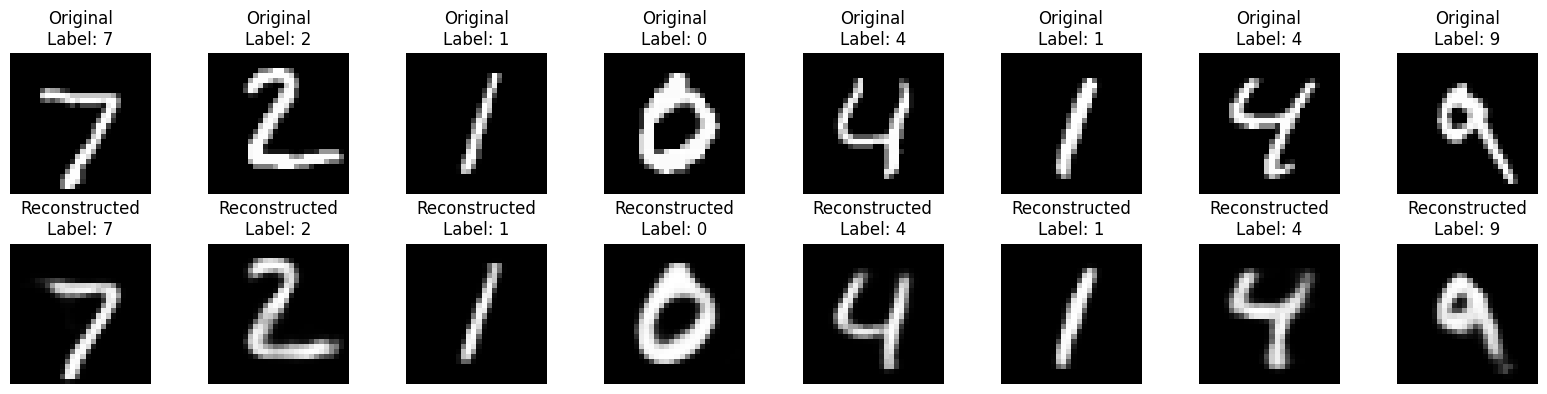

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

# YOUR CODE HERE:
conditions = F.one_hot(labels, 10)

with torch.no_grad():
    recon_images, mu, logvar = model(images, conditions)

def plot_images(original, reconstructed, conditions, n=8):
    labels = conditions.argmax(dim=1)
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Original\nLabel: {labels[i].item()}")
        plt.axis("off")
        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Reconstructed\nLabel: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(images, recon_images, conditions, n=8)

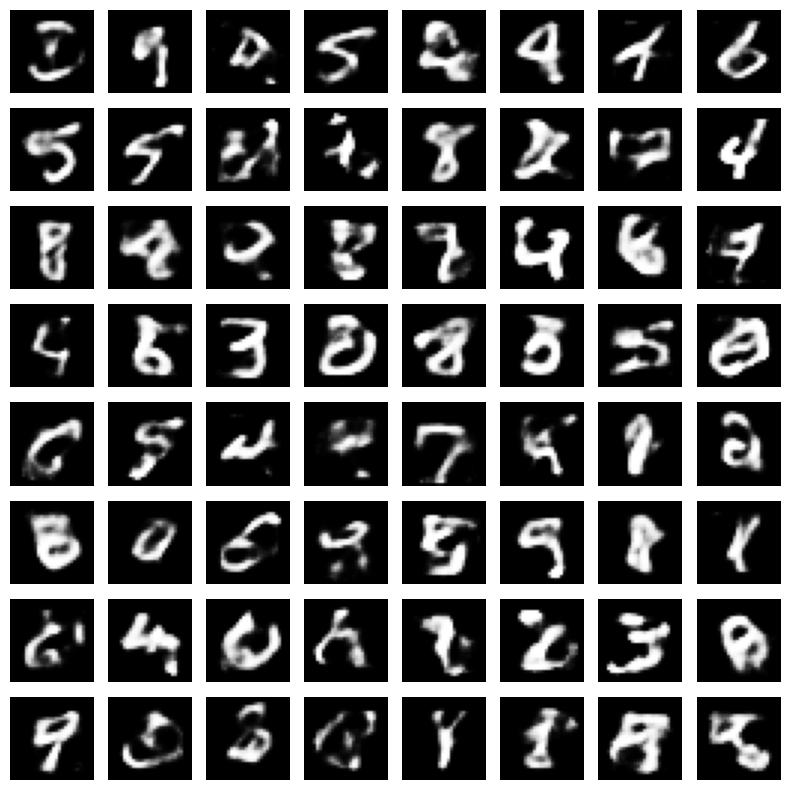

In [ ]:
latent_dim = 20

# ---- Визуализация: Генерация новых изображений из латентного пространства ----
with torch.no_grad():
    # Выборка латентных векторов z из стандартного нормального распределения
    # YOUR CODE HERE:
    z = torch.randn(64, latent_dim)
    z = z.to(DEVICE)

    random_labels = torch.randint(0, 10, (64,)).to(device)
    conditions = F.one_hot(random_labels, 10)

    generated_images = model.decoder(z, conditions)

def plot_generated(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28,28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_generated(generated_images)

### Улучшение модели

In [ ]:
class SuperConditionalEncoder(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=588, latent_dim=20):
        super(SuperConditionalEncoder, self).__init__()
        self.hidden_layer = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, 392)
        self.norm2 = nn.BatchNorm1d(392)
        self.hidden_layer3 = nn.Linear(392, 196)
        self.norm3 = nn.BatchNorm1d(196)
        self.out_mean = nn.Linear(196, latent_dim)
        self.out_disp = nn.Linear(196, latent_dim)

    def forward(self, x, c):
        x = torch.cat([x, c], 1)
        x = F.relu(self.hidden_layer(x))
        x = self.norm(x)
        x = F.relu(self.hidden_layer2(x))
        x = self.norm2(x)
        x = F.relu(self.hidden_layer3(x))
        x = self.norm3(x)
        mu = self.out_mean(x)
        logvar = self.out_disp(x)
        return mu, logvar

In [ ]:
class SuperConditionalDecoder(nn.Module):
    def __init__(self, latent_dim=20, condition_dim=10, hidden_dim=196, output_dim=784):
        super(SuperConditionalDecoder, self).__init__()
        self.hidden_layer = nn.Linear(latent_dim + condition_dim, 196)
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, 392)
        self.norm2 = nn.BatchNorm1d(392)
        self.hidden_layer3 = nn.Linear(392, 588)
        self.norm3 = nn.BatchNorm1d(588)
        self.out_layer = nn.Linear(588, output_dim)

    def forward(self, z, c):
        z = torch.cat([z, c], 1)
        hidden = F.relu(self.hidden_layer(z))
        hidden = self.norm(hidden)
        hidden = F.relu(self.hidden_layer2(hidden))
        hidden = self.norm2(hidden)
        hidden = F.relu(self.hidden_layer3(hidden))
        hidden = self.norm3(hidden)
        x_recon = torch.sigmoid(self.out_layer(hidden))
        return x_recon

In [ ]:
class SuperConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=400, latent_dim=50):
        super(SuperConditionalVAE, self).__init__()
        self.encoder = SuperConditionalEncoder(input_dim, condition_dim, hidden_dim, latent_dim)
        self.decoder = SuperConditionalDecoder(latent_dim, condition_dim, 196, input_dim)

    def reparameterize(self, mu, logvar):
        std =  torch.exp(0.5 * logvar)
        epsilon = torch.rand_like(logvar).to(DEVICE)
        z = mu + std * epsilon
        return z

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, c)
        return x_recon, mu, logvar

In [ ]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = dset.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = dset.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
hidden_dim = 600 # размерность скрытого слоя
latent_dim = 128 # размерность латентного пространства

model = SuperConditionalVAE(input_dim=784, condition_dim=10, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
num_epochs = 75 # Для получения более презентабельного результата используйте 50 и больше эпох
model.train()
for epoch in tqdm(range(1, num_epochs + 1)):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        ## YOUR CODE HERE
        ## TODO: Переместите входные данные (data) на правильное устройство
        ## TODO: Перенесите метки классов (labels) на правильное устройство
        ## TODO: С помощью функции F.one_hot получите массив векторов - закодированных меток классов для вашего батча
        ## TODO: Обнулите градиенты
        ## TODO: Вычислите выходы энкодера (recon_batch, mu, logvar)
        ## TODO: Рассчитайте функцию потерь (loss)
        ## TODO: Выполните обратное распространение градиентов с учетом функции потерь
        ## TODO: Обновите общий loss, добавив текущий loss
        ## TODO: Выполните шаг оптимизатора
        labels = labels.to(DEVICE)
        data = data.to(DEVICE)
        conditions = F.one_hot(labels, 10)

        optimizer.zero_grad()

        x_recon, mean, log_var = model(data, conditions)
        loss = loss_function(x_recon, data, mean, log_var)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1 [0/60000 (0%)]	Loss: 608.333984
Epoch: 1 [12800/60000 (21%)]	Loss: 138.577286
Epoch: 1 [25600/60000 (43%)]	Loss: 114.629616
Epoch: 1 [38400/60000 (64%)]	Loss: 109.828415
Epoch: 1 [51200/60000 (85%)]	Loss: 102.382729


  1%|▏         | 1/75 [00:08<10:03,  8.16s/it]

====> Epoch: 1 Average loss: 155.4875
Epoch: 2 [0/60000 (0%)]	Loss: 101.073532
Epoch: 2 [12800/60000 (21%)]	Loss: 99.333214
Epoch: 2 [25600/60000 (43%)]	Loss: 93.087349
Epoch: 2 [38400/60000 (64%)]	Loss: 91.545540
Epoch: 2 [51200/60000 (85%)]	Loss: 90.818214


  3%|▎         | 2/75 [00:16<09:46,  8.03s/it]

====> Epoch: 2 Average loss: 94.9201
Epoch: 3 [0/60000 (0%)]	Loss: 95.390335
Epoch: 3 [12800/60000 (21%)]	Loss: 91.546928
Epoch: 3 [25600/60000 (43%)]	Loss: 92.572800
Epoch: 3 [38400/60000 (64%)]	Loss: 92.254196
Epoch: 3 [51200/60000 (85%)]	Loss: 91.012291


  4%|▍         | 3/75 [00:23<09:19,  7.77s/it]

====> Epoch: 3 Average loss: 89.4350
Epoch: 4 [0/60000 (0%)]	Loss: 89.308357
Epoch: 4 [12800/60000 (21%)]	Loss: 88.405228
Epoch: 4 [25600/60000 (43%)]	Loss: 86.763954
Epoch: 4 [38400/60000 (64%)]	Loss: 84.700790
Epoch: 4 [51200/60000 (85%)]	Loss: 83.903694


  5%|▌         | 4/75 [00:31<09:22,  7.92s/it]

====> Epoch: 4 Average loss: 86.5705
Epoch: 5 [0/60000 (0%)]	Loss: 84.220810
Epoch: 5 [12800/60000 (21%)]	Loss: 84.692528
Epoch: 5 [25600/60000 (43%)]	Loss: 87.561752
Epoch: 5 [38400/60000 (64%)]	Loss: 83.149864
Epoch: 5 [51200/60000 (85%)]	Loss: 84.491966


  7%|▋         | 5/75 [00:39<09:09,  7.85s/it]

====> Epoch: 5 Average loss: 84.7317
Epoch: 6 [0/60000 (0%)]	Loss: 83.463623
Epoch: 6 [12800/60000 (21%)]	Loss: 81.963577
Epoch: 6 [25600/60000 (43%)]	Loss: 83.291267
Epoch: 6 [38400/60000 (64%)]	Loss: 81.158470
Epoch: 6 [51200/60000 (85%)]	Loss: 83.334473


  8%|▊         | 6/75 [00:47<08:58,  7.81s/it]

====> Epoch: 6 Average loss: 83.3731
Epoch: 7 [0/60000 (0%)]	Loss: 82.304909
Epoch: 7 [12800/60000 (21%)]	Loss: 84.516411
Epoch: 7 [25600/60000 (43%)]	Loss: 82.720055
Epoch: 7 [38400/60000 (64%)]	Loss: 82.511032
Epoch: 7 [51200/60000 (85%)]	Loss: 79.957901


  9%|▉         | 7/75 [00:55<08:57,  7.90s/it]

====> Epoch: 7 Average loss: 82.3506
Epoch: 8 [0/60000 (0%)]	Loss: 81.368881
Epoch: 8 [12800/60000 (21%)]	Loss: 78.472443
Epoch: 8 [25600/60000 (43%)]	Loss: 84.561737
Epoch: 8 [38400/60000 (64%)]	Loss: 80.349312
Epoch: 8 [51200/60000 (85%)]	Loss: 82.702881


 11%|█         | 8/75 [01:02<08:44,  7.83s/it]

====> Epoch: 8 Average loss: 81.4349
Epoch: 9 [0/60000 (0%)]	Loss: 80.129501
Epoch: 9 [12800/60000 (21%)]	Loss: 79.118622
Epoch: 9 [25600/60000 (43%)]	Loss: 83.622467
Epoch: 9 [38400/60000 (64%)]	Loss: 82.408531
Epoch: 9 [51200/60000 (85%)]	Loss: 78.683121


 12%|█▏        | 9/75 [01:10<08:37,  7.85s/it]

====> Epoch: 9 Average loss: 80.7825
Epoch: 10 [0/60000 (0%)]	Loss: 79.220993
Epoch: 10 [12800/60000 (21%)]	Loss: 78.049187
Epoch: 10 [25600/60000 (43%)]	Loss: 84.770248
Epoch: 10 [38400/60000 (64%)]	Loss: 83.493958
Epoch: 10 [51200/60000 (85%)]	Loss: 83.257751


 13%|█▎        | 10/75 [01:18<08:34,  7.91s/it]

====> Epoch: 10 Average loss: 80.1757
Epoch: 11 [0/60000 (0%)]	Loss: 80.370834
Epoch: 11 [12800/60000 (21%)]	Loss: 80.689728
Epoch: 11 [25600/60000 (43%)]	Loss: 78.607140
Epoch: 11 [38400/60000 (64%)]	Loss: 78.712845
Epoch: 11 [51200/60000 (85%)]	Loss: 79.343231


 15%|█▍        | 11/75 [01:26<08:16,  7.76s/it]

====> Epoch: 11 Average loss: 79.7359
Epoch: 12 [0/60000 (0%)]	Loss: 75.928596
Epoch: 12 [12800/60000 (21%)]	Loss: 83.535316
Epoch: 12 [25600/60000 (43%)]	Loss: 79.982132
Epoch: 12 [38400/60000 (64%)]	Loss: 79.084709
Epoch: 12 [51200/60000 (85%)]	Loss: 80.202095


 16%|█▌        | 12/75 [01:34<08:15,  7.86s/it]

====> Epoch: 12 Average loss: 79.2997
Epoch: 13 [0/60000 (0%)]	Loss: 78.065010
Epoch: 13 [12800/60000 (21%)]	Loss: 79.102837
Epoch: 13 [25600/60000 (43%)]	Loss: 77.004318
Epoch: 13 [38400/60000 (64%)]	Loss: 81.302666


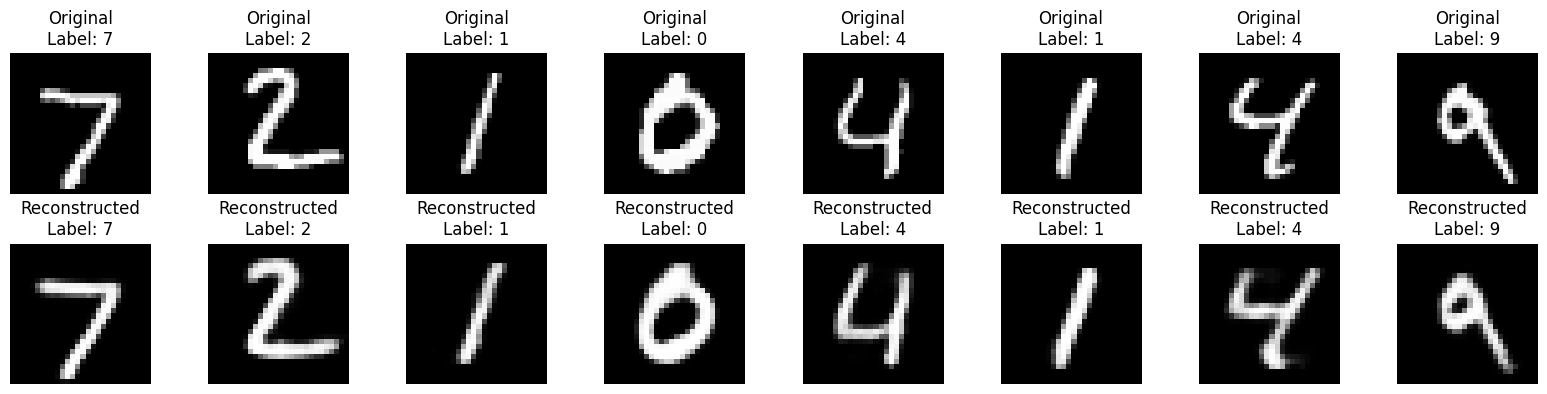

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

# YOUR CODE HERE:
conditions = F.one_hot(labels, 10)

with torch.no_grad():
    recon_images, mu, logvar = model(images, conditions)

def plot_images(original, reconstructed, conditions, n=8):
    labels = conditions.argmax(dim=1)
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Original\nLabel: {labels[i].item()}")
        plt.axis("off")
        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Reconstructed\nLabel: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(images, recon_images, conditions, n=8)

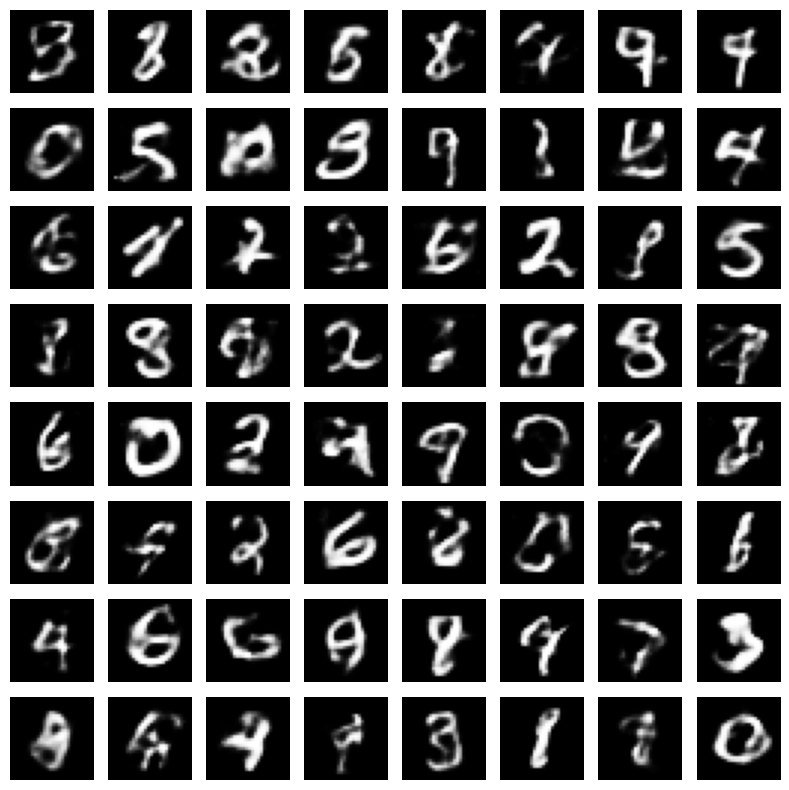

In [ ]:
latent_dim = 128

# ---- Визуализация: Генерация новых изображений из латентного пространства ----
with torch.no_grad():
    # Выборка латентных векторов z из стандартного нормального распределения
    # YOUR CODE HERE:
    z = torch.randn(64, latent_dim)
    z = z.to(DEVICE)

    random_labels = torch.randint(0, 10, (64,)).to(device)
    conditions = F.one_hot(random_labels, 10)

    generated_images = model.decoder(z, conditions)

def plot_generated(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28,28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_generated(generated_images)

# Задание 2 (GAN)

## GAN


In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim = 100, output_shape = (1, 28, 28)):
        super(Generator, self).__init__()
        self.output_shape = output_shape
        self.output_size = output_shape[0] * output_shape[1] * output_shape[2]
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.output_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.fc(z)
        img = img.view(img.size(0), *self.output_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()
        self.input_size = input_shape[0] * input_shape[1] * input_shape[2]
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        result = self.fc(img)
        return result

In [ ]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = dset.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = dset.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.BCELoss()

generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001)

In [ ]:
from tqdm import tqdm

epochs = 50
for epoch in tqdm(range(epochs)):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)

        # Создайте метки для реальных и фейковых изображений
        real_labels = torch.ones(batch_size, 1).to(DEVICE)
        fake_labels = torch.zeros(batch_size, 1).to(DEVICE)

        # Обучение дискриминатора
        # TODO: Обнулите градиенты дискриминатора
        optimizer_d.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        # TODO: Выполните обратное распространение ошибки


        noise = torch.randn(batch_size, 100).to(DEVICE)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        # TODO: Выполните обратное распространение ошибки для дискриминатора

        com_loss = d_loss_real + d_loss_fake
        com_loss.backward()

        # TODO: Выполните шаг оптимизатора дискриминатора
        optimizer_d.step()

        # Обучение генератора
        # TODO: Обнулите градиенты генератора
        optimizer_g.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()

        optimizer_g.step()

    # TODO: Выведите результаты текущей эпохи: сумму D Loss и значение G Loss
    print(f'Epoch [{epoch}/{epochs}], D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}')


  2%|▏         | 1/50 [00:07<06:19,  7.75s/it]

Epoch [0/50], D Loss: 0.6019, G Loss: 1.6241


  4%|▍         | 2/50 [00:16<06:27,  8.08s/it]

Epoch [1/50], D Loss: 0.8004, G Loss: 2.9835


  6%|▌         | 3/50 [00:24<06:24,  8.18s/it]

Epoch [2/50], D Loss: 1.0741, G Loss: 3.1576


  8%|▊         | 4/50 [00:32<06:08,  8.02s/it]

Epoch [3/50], D Loss: 0.1044, G Loss: 3.4714


 10%|█         | 5/50 [00:40<06:06,  8.15s/it]

Epoch [4/50], D Loss: 0.6788, G Loss: 3.5270


 12%|█▏        | 6/50 [00:48<06:01,  8.22s/it]

Epoch [5/50], D Loss: 0.9388, G Loss: 2.4443


 14%|█▍        | 7/50 [00:56<05:49,  8.12s/it]

Epoch [6/50], D Loss: 0.1718, G Loss: 5.3773


 16%|█▌        | 8/50 [01:05<05:43,  8.18s/it]

Epoch [7/50], D Loss: 0.2679, G Loss: 3.8645


 18%|█▊        | 9/50 [01:13<05:37,  8.24s/it]

Epoch [8/50], D Loss: 0.5362, G Loss: 3.0559


 20%|██        | 10/50 [01:21<05:26,  8.17s/it]

Epoch [9/50], D Loss: 0.0746, G Loss: 6.4471


 22%|██▏       | 11/50 [01:29<05:18,  8.17s/it]

Epoch [10/50], D Loss: 0.1129, G Loss: 5.2475


 24%|██▍       | 12/50 [01:38<05:13,  8.26s/it]

Epoch [11/50], D Loss: 0.2862, G Loss: 5.7571


 26%|██▌       | 13/50 [01:46<05:07,  8.31s/it]

Epoch [12/50], D Loss: 0.2544, G Loss: 4.3232


 28%|██▊       | 14/50 [01:54<04:55,  8.20s/it]

Epoch [13/50], D Loss: 0.0324, G Loss: 4.8013


 30%|███       | 15/50 [02:03<04:50,  8.31s/it]

Epoch [14/50], D Loss: 0.0609, G Loss: 8.3195


 32%|███▏      | 16/50 [02:11<04:43,  8.35s/it]

Epoch [15/50], D Loss: 0.0527, G Loss: 3.9847


 34%|███▍      | 17/50 [02:19<04:29,  8.17s/it]

Epoch [16/50], D Loss: 0.0792, G Loss: 4.1809


 36%|███▌      | 18/50 [02:27<04:22,  8.20s/it]

Epoch [17/50], D Loss: 0.1246, G Loss: 4.1428


 38%|███▊      | 19/50 [02:35<04:15,  8.25s/it]

Epoch [18/50], D Loss: 0.3112, G Loss: 4.7083


 40%|████      | 20/50 [02:43<04:02,  8.08s/it]

Epoch [19/50], D Loss: 0.1741, G Loss: 6.5815


 42%|████▏     | 21/50 [02:51<03:56,  8.16s/it]

Epoch [20/50], D Loss: 0.0494, G Loss: 5.0801


 44%|████▍     | 22/50 [03:00<03:50,  8.22s/it]

Epoch [21/50], D Loss: 0.0356, G Loss: 4.6018


 46%|████▌     | 23/50 [03:08<03:38,  8.09s/it]

Epoch [22/50], D Loss: 0.0294, G Loss: 5.9169


 48%|████▊     | 24/50 [03:16<03:32,  8.18s/it]

Epoch [23/50], D Loss: 0.0776, G Loss: 5.7399


 50%|█████     | 25/50 [03:24<03:26,  8.25s/it]

Epoch [24/50], D Loss: 0.3886, G Loss: 6.4191


 52%|█████▏    | 26/50 [03:32<03:15,  8.13s/it]

Epoch [25/50], D Loss: 0.7670, G Loss: 5.0148


 54%|█████▍    | 27/50 [03:41<03:09,  8.23s/it]

Epoch [26/50], D Loss: 0.2615, G Loss: 4.6363


 56%|█████▌    | 28/50 [03:49<03:02,  8.29s/it]

Epoch [27/50], D Loss: 0.2066, G Loss: 4.8225


 58%|█████▊    | 29/50 [03:57<02:50,  8.13s/it]

Epoch [28/50], D Loss: 0.1746, G Loss: 4.6462


 60%|██████    | 30/50 [04:05<02:43,  8.18s/it]

Epoch [29/50], D Loss: 0.4512, G Loss: 6.8185


 62%|██████▏   | 31/50 [04:13<02:36,  8.23s/it]

Epoch [30/50], D Loss: 0.1681, G Loss: 3.3256


 64%|██████▍   | 32/50 [04:21<02:26,  8.11s/it]

Epoch [31/50], D Loss: 0.2171, G Loss: 6.2025


 66%|██████▌   | 33/50 [04:30<02:18,  8.13s/it]

Epoch [32/50], D Loss: 0.2074, G Loss: 7.6692


 68%|██████▊   | 34/50 [04:38<02:11,  8.22s/it]

Epoch [33/50], D Loss: 0.3299, G Loss: 6.0359


 70%|███████   | 35/50 [04:46<02:02,  8.18s/it]

Epoch [34/50], D Loss: 0.2612, G Loss: 4.6312


 72%|███████▏  | 36/50 [04:54<01:54,  8.18s/it]

Epoch [35/50], D Loss: 0.2369, G Loss: 4.7217


 74%|███████▍  | 37/50 [05:03<01:47,  8.28s/it]

Epoch [36/50], D Loss: 0.1097, G Loss: 3.8878


 76%|███████▌  | 38/50 [05:11<01:39,  8.33s/it]

Epoch [37/50], D Loss: 0.4929, G Loss: 3.6600


 78%|███████▊  | 39/50 [05:19<01:29,  8.17s/it]

Epoch [38/50], D Loss: 0.1180, G Loss: 4.3471


 80%|████████  | 40/50 [05:27<01:22,  8.26s/it]

Epoch [39/50], D Loss: 0.1939, G Loss: 4.1226


 82%|████████▏ | 41/50 [05:36<01:14,  8.33s/it]

Epoch [40/50], D Loss: 0.3288, G Loss: 4.9744


 84%|████████▍ | 42/50 [05:44<01:05,  8.14s/it]

Epoch [41/50], D Loss: 0.1941, G Loss: 4.2257


 86%|████████▌ | 43/50 [05:52<00:57,  8.20s/it]

Epoch [42/50], D Loss: 0.1004, G Loss: 4.5160


 88%|████████▊ | 44/50 [06:00<00:49,  8.22s/it]

Epoch [43/50], D Loss: 0.2141, G Loss: 4.4956


 90%|█████████ | 45/50 [06:08<00:40,  8.06s/it]

Epoch [44/50], D Loss: 0.5370, G Loss: 3.6460


 92%|█████████▏| 46/50 [06:16<00:32,  8.15s/it]

Epoch [45/50], D Loss: 0.1808, G Loss: 5.0657


 94%|█████████▍| 47/50 [06:25<00:24,  8.24s/it]

Epoch [46/50], D Loss: 0.2441, G Loss: 5.2894


 96%|█████████▌| 48/50 [06:33<00:16,  8.11s/it]

Epoch [47/50], D Loss: 0.2420, G Loss: 5.3507


 98%|█████████▊| 49/50 [06:41<00:08,  8.19s/it]

Epoch [48/50], D Loss: 0.1235, G Loss: 6.3141


100%|██████████| 50/50 [06:49<00:00,  8.20s/it]

Epoch [49/50], D Loss: 0.2727, G Loss: 3.8655


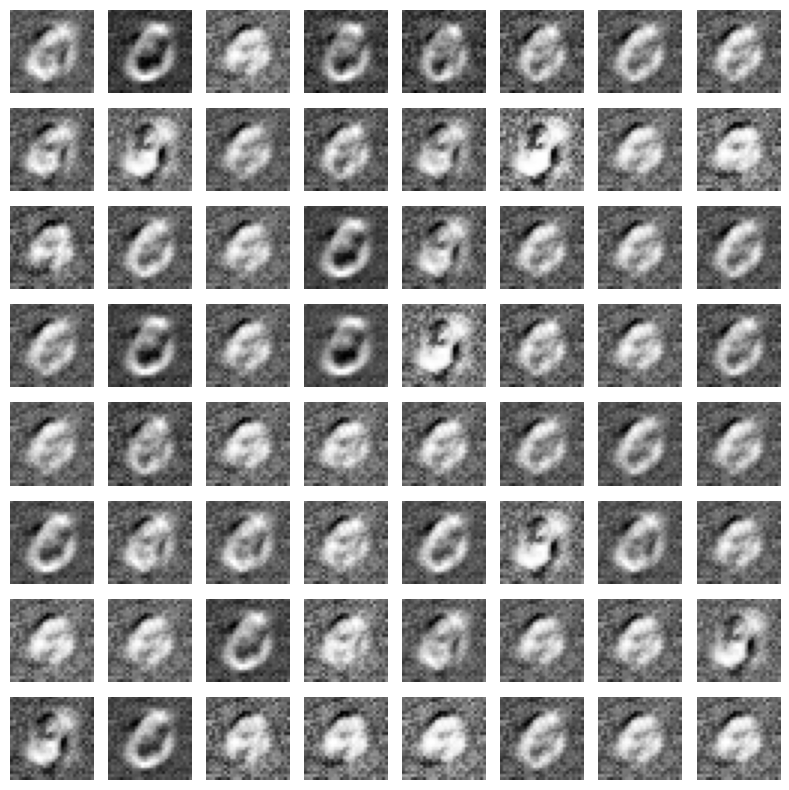

In [ ]:
import matplotlib.pyplot as plt

# YOUR CODE HERE:
z = torch.randn(64, 100)
generated_images = generator(noise).cpu().detach()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = generated_images[i].view(28,28).numpy()
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Conditional GAN

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10, output_shape=(1, 28, 28)):
        super(ConditionalGenerator, self).__init__()
        self.output_shape = output_shape
        self.img_size = output_shape[0] * output_shape[1] * output_shape[2]
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, self.img_size),
            nn.Tanh()
        )

    def forward(self, z, c):
        x = torch.cat([z, c], 1)
        x = self.fc(x)
        x = x.view(x.size(0), *self.output_shape)
        return x

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), num_classes=10):
        super(ConditionalDiscriminator, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        self.img_dim = input_shape[0] * input_shape[1] * input_shape[2]

        input_dim = self.img_dim + num_classes

        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, c):
        img_flat = img.flatten(start_dim=1)
        x = torch.cat([img_flat, c], dim=1)
        x = self.fc(x)
        return x

In [ ]:
batch_size = 128
lr = 0.0002
noise_dim = 100
num_classes = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
import torchvision
import torch.optim as optim

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

generator = ConditionalGenerator(noise_dim=noise_dim, num_classes=num_classes, output_shape=(1, 28, 28)).to(DEVICE)
discriminator = ConditionalDiscriminator(input_shape=(1, 28, 28), num_classes=num_classes).to(DEVICE)
criterion = nn.BCELoss()

optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

In [ ]:
from tqdm import tqdm

epochs = 50
for epoch in tqdm(range(epochs)):
    for i, (real_images, labels) in enumerate(train_loader):
        labels = labels.to(DEVICE)
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)
        conditions = F.one_hot(labels, num_classes)

        # Создайте метки для реальных и фейковых изображений
        real_labels = torch.ones(batch_size, 1).to(DEVICE)
        fake_labels = torch.zeros(batch_size, 1).to(DEVICE)

        random_tensor = torch.randint(0, 10, (len(labels),)).to(DEVICE)
        conditions_random = F.one_hot(random_tensor, num_classes)

        optimizer_d.zero_grad()
        outputs = discriminator(real_images, conditions)
        d_loss_real = criterion(outputs, real_labels)
        # TODO: Выполните обратное распространение ошибки

        # удалить

        noise = torch.randn(batch_size, 100).to(DEVICE)


        # случайный лейблы генерить и переловать сюда и генератор

        fake_images = generator(noise, conditions_random)
        outputs = discriminator(fake_images.detach(), conditions_random)
        d_loss_fake = criterion(outputs, fake_labels)
        # TODO: Выполните обратное распространение ошибки для дискриминатора

        com_loss = d_loss_real + d_loss_fake

        # сложить лосы и backward
        com_loss.backward()

        # TODO: Выполните шаг оптимизатора дискриминатора
        optimizer_d.step()

        # Обучение генератора
        # TODO: Обнулите градиенты генератора
        optimizer_g.zero_grad()
        outputs = discriminator(fake_images, conditions_random)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()

        optimizer_g.step()

    # TODO: Выведите результаты текущей эпохи: сумму D Loss и значение G Loss
    print(f'Epoch [{epoch}/{epochs}], D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}')

  2%|▏         | 1/50 [00:13<11:15, 13.79s/it]

Epoch [0/50], D Loss: 1.1214, G Loss: 4.0018


  4%|▍         | 2/50 [00:26<10:39, 13.32s/it]

Epoch [1/50], D Loss: 0.0551, G Loss: 7.2900


  6%|▌         | 3/50 [00:39<10:22, 13.24s/it]

Epoch [2/50], D Loss: 0.6660, G Loss: 2.3175


  8%|▊         | 4/50 [00:53<10:11, 13.30s/it]

Epoch [3/50], D Loss: 0.9374, G Loss: 1.3956


 10%|█         | 5/50 [01:06<09:56, 13.25s/it]

Epoch [4/50], D Loss: 6.3590, G Loss: 4.0071


 12%|█▏        | 6/50 [01:20<09:48, 13.38s/it]

Epoch [5/50], D Loss: 0.7235, G Loss: 1.2496


 14%|█▍        | 7/50 [01:33<09:33, 13.34s/it]

Epoch [6/50], D Loss: 0.1387, G Loss: 4.5996


 16%|█▌        | 8/50 [01:46<09:23, 13.41s/it]

Epoch [7/50], D Loss: 0.7478, G Loss: 2.7011


 18%|█▊        | 9/50 [02:00<09:08, 13.38s/it]

Epoch [8/50], D Loss: 0.6398, G Loss: 2.2303


 20%|██        | 10/50 [02:13<08:55, 13.39s/it]

Epoch [9/50], D Loss: 0.2548, G Loss: 4.7998


 22%|██▏       | 11/50 [02:27<08:44, 13.45s/it]

Epoch [10/50], D Loss: 0.2717, G Loss: 6.0495


 24%|██▍       | 12/50 [02:40<08:29, 13.39s/it]

Epoch [11/50], D Loss: 0.5836, G Loss: 4.5136


 26%|██▌       | 13/50 [02:53<08:14, 13.37s/it]

Epoch [12/50], D Loss: 0.1070, G Loss: 5.0353


 28%|██▊       | 14/50 [03:07<07:59, 13.32s/it]

Epoch [13/50], D Loss: 0.1919, G Loss: 5.7479


 30%|███       | 15/50 [03:20<07:45, 13.29s/it]

Epoch [14/50], D Loss: 0.2418, G Loss: 5.7206


 32%|███▏      | 16/50 [03:33<07:32, 13.30s/it]

Epoch [15/50], D Loss: 0.0285, G Loss: 8.5130


 34%|███▍      | 17/50 [03:46<07:19, 13.31s/it]

Epoch [16/50], D Loss: 0.2245, G Loss: 5.8606


 36%|███▌      | 18/50 [04:00<07:04, 13.27s/it]

Epoch [17/50], D Loss: 0.1144, G Loss: 6.9853


 38%|███▊      | 19/50 [04:13<06:48, 13.17s/it]

Epoch [18/50], D Loss: 0.1826, G Loss: 7.0003


 40%|████      | 20/50 [04:26<06:36, 13.21s/it]

Epoch [19/50], D Loss: 0.2681, G Loss: 6.6721


 42%|████▏     | 21/50 [04:39<06:22, 13.19s/it]

Epoch [20/50], D Loss: 0.0224, G Loss: 6.9319


 44%|████▍     | 22/50 [04:52<06:07, 13.13s/it]

Epoch [21/50], D Loss: 0.1120, G Loss: 7.8012


 46%|████▌     | 23/50 [05:05<05:53, 13.08s/it]

Epoch [22/50], D Loss: 0.0461, G Loss: 9.2287


 48%|████▊     | 24/50 [05:18<05:40, 13.10s/it]

Epoch [23/50], D Loss: 0.0786, G Loss: 8.0369


 50%|█████     | 25/50 [05:31<05:27, 13.10s/it]

Epoch [24/50], D Loss: 0.0850, G Loss: 12.5389


 52%|█████▏    | 26/50 [05:44<05:13, 13.07s/it]

Epoch [25/50], D Loss: 0.1234, G Loss: 7.5444


 54%|█████▍    | 27/50 [05:57<05:01, 13.12s/it]

Epoch [26/50], D Loss: 0.0883, G Loss: 6.0836


 56%|█████▌    | 28/50 [06:10<04:48, 13.10s/it]

Epoch [27/50], D Loss: 0.1370, G Loss: 5.9319


 58%|█████▊    | 29/50 [06:23<04:34, 13.06s/it]

Epoch [28/50], D Loss: 0.2079, G Loss: 4.7838


 60%|██████    | 30/50 [06:36<04:20, 13.04s/it]

Epoch [29/50], D Loss: 0.2871, G Loss: 7.2494


 62%|██████▏   | 31/50 [06:50<04:11, 13.22s/it]

Epoch [30/50], D Loss: 0.3188, G Loss: 7.2226


 64%|██████▍   | 32/50 [07:04<04:01, 13.39s/it]

Epoch [31/50], D Loss: 0.1251, G Loss: 9.1198


 66%|██████▌   | 33/50 [07:18<03:49, 13.48s/it]

Epoch [32/50], D Loss: 0.1730, G Loss: 5.8382


 68%|██████▊   | 34/50 [07:31<03:36, 13.50s/it]

Epoch [33/50], D Loss: 0.2225, G Loss: 4.3174


 70%|███████   | 35/50 [07:45<03:22, 13.48s/it]

Epoch [34/50], D Loss: 0.3283, G Loss: 4.8667


 72%|███████▏  | 36/50 [07:58<03:07, 13.42s/it]

Epoch [35/50], D Loss: 0.1252, G Loss: 6.2338


 74%|███████▍  | 37/50 [08:11<02:53, 13.35s/it]

Epoch [36/50], D Loss: 0.1012, G Loss: 5.3998


 76%|███████▌  | 38/50 [08:24<02:39, 13.31s/it]

Epoch [37/50], D Loss: 0.4379, G Loss: 4.7317


 78%|███████▊  | 39/50 [08:37<02:25, 13.27s/it]

Epoch [38/50], D Loss: 0.1543, G Loss: 6.2547


 80%|████████  | 40/50 [08:51<02:12, 13.28s/it]

Epoch [39/50], D Loss: 0.3164, G Loss: 5.9204


 82%|████████▏ | 41/50 [09:04<02:00, 13.44s/it]

Epoch [40/50], D Loss: 0.1235, G Loss: 4.1870


 84%|████████▍ | 42/50 [09:18<01:47, 13.48s/it]

Epoch [41/50], D Loss: 0.4099, G Loss: 4.5515


 86%|████████▌ | 43/50 [09:31<01:34, 13.44s/it]

Epoch [42/50], D Loss: 0.3490, G Loss: 3.7143


 88%|████████▊ | 44/50 [09:45<01:20, 13.42s/it]

Epoch [43/50], D Loss: 0.2790, G Loss: 4.4985


 90%|█████████ | 45/50 [09:58<01:07, 13.41s/it]

Epoch [44/50], D Loss: 0.3036, G Loss: 3.5630


 92%|█████████▏| 46/50 [10:11<00:53, 13.34s/it]

Epoch [45/50], D Loss: 0.2794, G Loss: 5.3388


 94%|█████████▍| 47/50 [10:24<00:39, 13.27s/it]

Epoch [46/50], D Loss: 0.4501, G Loss: 2.2590


 96%|█████████▌| 48/50 [10:38<00:26, 13.25s/it]

Epoch [47/50], D Loss: 0.2320, G Loss: 4.1306


 98%|█████████▊| 49/50 [10:51<00:13, 13.32s/it]

Epoch [48/50], D Loss: 0.2884, G Loss: 4.3025


100%|██████████| 50/50 [11:05<00:00, 13.31s/it]

Epoch [49/50], D Loss: 0.4505, G Loss: 5.0268


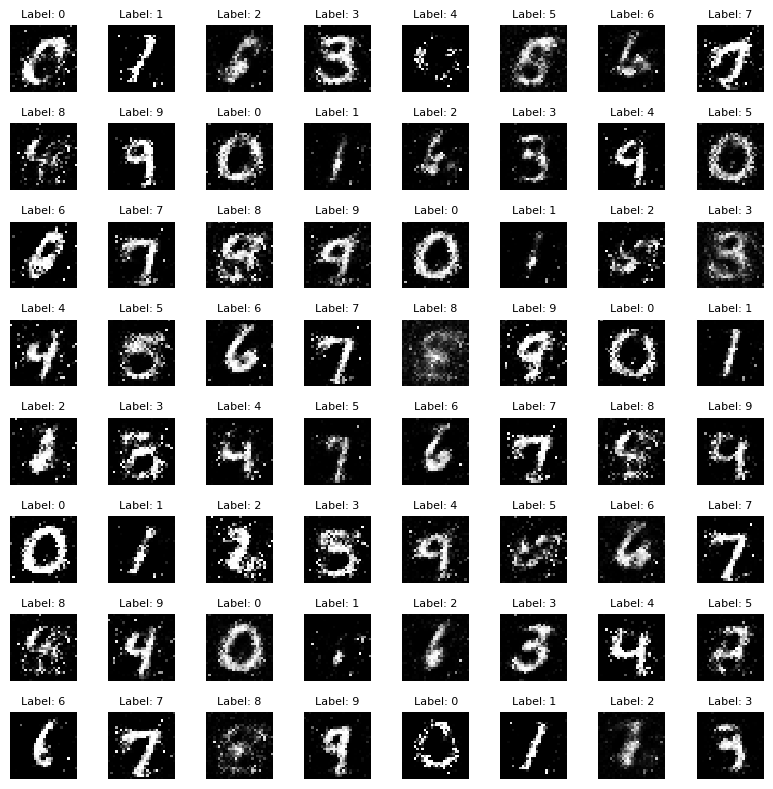

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    sample_noise = torch.randn(64, 100, device=DEVICE) # 64 образца случайного шума, каждый из которых имеет размерность noise_dim
    sample_labels = torch.arange(0, 64, device=DEVICE) % num_classes
    sample_labels_onehot = F.one_hot(sample_labels, num_classes)# С помощью функции F.one_hot получите массив векторов - закодированных меток классов для вашего батча
    fake_samples = generator(sample_noise, sample_labels_onehot)

    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = fake_samples[i].cpu().view(28, 28).numpy()
        ax.imshow(img, cmap="gray", interpolation="nearest")
        ax.set_title(f"Label: {sample_labels[i].item()}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Линейная интерполяция

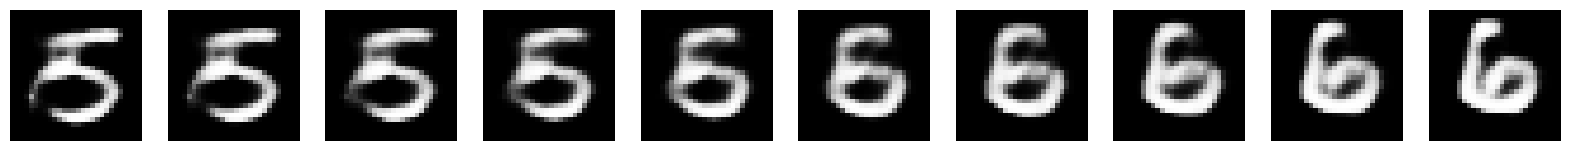

In [ ]:
import numpy as np
def interpolate_images(generator, first_dim, num_classes, class1, class2, num_interpolations=10):
  z1 = torch.randn(1, first_dim)
  z2 = torch.randn(1, first_dim)

  l1 = torch.zeros(1, num_classes)
  l1[0, class1] = 1  # Класс 0
  l2 = torch.zeros(1, num_classes)
  l2[0, class2] = 1  # Класс 1

  num_interpolations = 10
  interpolated_images = []

  for alpha in np.linspace(0, 1, num_interpolations):
      z = alpha * z1 + (1 - alpha) * z2
      l = alpha * l1 + (1 - alpha) * l2

      z = z.to(DEVICE)
      l = l.to(DEVICE)

      with torch.no_grad():
          generated_image = generator(z, l)

      interpolated_images.insert(0, generated_image.squeeze().cpu().numpy())

  return interpolated_images

def plot_interpolated_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, img in enumerate(images):
        axes[i].imshow(img.reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.show()

interpolated_images = interpolate_images(model.decoder, latent_dim, num_classes, 5, 6)
plot_interpolated_images(interpolated_images)

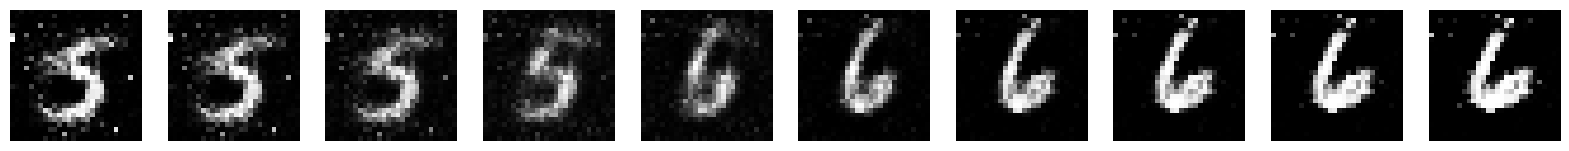

In [ ]:
interpolated_images = interpolate_images(generator, noise_dim, num_classes, 5, 6)
plot_interpolated_images(interpolated_images)